In [2]:
import torch
import torch.nn as nn
import torch.distributions as tdist

import dataloader

In [231]:
class DiffusionModel(nn.Module):
    def __init__(self, beta):
        super(DiffusionModel, self).__init__()
        self.device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.beta = beta.to(self.device) # Decay schedule
        self.T = beta.shape[0]
        
        self.conv = nn.Conv2d(1, 16, 3, padding =1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, 3, padding=1)
        
        self.gelu = nn.GELU()
        
    def alphabar(self, t):
        alpha = torch.zeros(t.shape[0], device=self.device)
        for idx, s in enumerate(t):
            alpha[idx] = torch.prod(self.beta[0:s])
        return alpha
    
    def embedtime(self, t, embedding_size, dimensions):
        emb = torch.zeros((embedding_size // 2) * t.shape[0], device=self.device).reshape(t.shape[0], embedding_size // 2)
        emb2 = torch.zeros((embedding_size // 2) * t.shape[0], device=self.device).reshape(t.shape[0], embedding_size // 2)
        s = torch.linspace(2, embedding_size // 2, embedding_size // 2, device=self.device)
        for idx, samp in enumerate(t):
            emb[idx] = torch.sin(2 * s * torch.pi * samp / self.T)
            emb2[idx] = torch.cos(2 * s * torch.pi * samp / self.T)

        return torch.cat([emb, emb2], dim = 1).view(-1, embedding_size, 1, 1).repeat(1, 1, dimensions, dimensions)
    
    def sample_image(self):
        samples = torch.zeros((self.T + 1, 784), device=self.device)
        
        samples[self.T] = torch.randn(784, device=self.device)
        
        with torch.no_grad():
            for t in torch.arange(self.T - 1, 0, -1):
                beta = self.beta[t]
                alfa = 1 - beta
                alfabar = self.alphabar(torch.tensor([t + 1], device=self.device))
                z = torch.randn(784, device=self.device)
                xt = samples[t + 1]
                eps = self.forward(xt.view(1, 1, 28, 28), torch.tensor([t + 1], device=self.device)).view(784)
                samples[t] = (xt - beta * eps / (torch.sqrt(1 - alfabar))) / torch.sqrt(alfa) + beta * z
            
            beta = self.beta[0]
            alfa = 1 - beta
            alfabar  = self.alphabar(torch.tensor([1], device=self.device))
            xt = samples[1]
            eps = self.forward(xt.view(1, 1, 28, 28), torch.tensor([1], device=self.device)).view(784)
            samples[0] = (xt - beta * eps / (torch.sqrt(1 - alfabar))) / torch.sqrt(alfa)
        
        return samples
        
    def forward(self, x, t):
        
        x = self.conv(x) + self.embedtime(t, 16, 28)
        x = self.gelu(x)
        x = self.conv2(x) + self.embedtime(t, 32, 28)
        x = self.gelu(x)
        x = self.conv3(x) + self.embedtime(t, 16, 28)
        x = self.gelu(x)
        x = self.conv4(x)   
        return x

In [ ]:
class DiffusionModel2(nn.Module):
    def __init__(self, beta):
        super(DiffusionModel2, self).__init__()
        
        self.beta = beta # Decay schedule
        self.T = beta.shape[0]
        # VERY PRIMITIVE UNET
        
        # ENTRY
        self.t1 = nn.Linear(16, 28 * 28)
        self.c11 = nn.Conv2d(1, 16, 3, padding=1)   # (1, 28, 28) -> (16, 28, 28)
        self.c12 = nn.Conv2d(16, 16, 3, padding=1)  # (16, 28, 28) -> (16, 28, 28)
        self.p1 = nn.MaxPool2d(2) # (16, 28, 28) -> (16, 14, 14)

        # BOTTOM
        self.t2 = nn.Linear(8, 14 * 14)
        self.c21 = nn.Conv2d(16, 32, 3, padding = 1) # (16, 14, 14) -> (32, 14, 14)
        self.c22 = nn.Conv2d(32, 32, 3, padding = 1) # (32, 14, 14) -> (32, 14, 14)
        self.p2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # (32, 14, 14) -> (32, 28, 28)
        
        # OUT
        self.t3 = nn.Linear(16, 28 * 28)
        self.c31 = nn.Conv2d(32, 16, 3, padding=1) # (32, 28, 28) -> (16, 28, 28)
        self.c32 = nn.Conv2d(16, 1, 3, padding=1) # (16, 28, 28) -> (1, 28, 28)
        
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
    def alphabar(self, t):
        alpha = torch.zeros(t.shape[0])
        for idx, s in enumerate(t):
            alpha[idx] = torch.prod(1 - self.beta[1:s])
        return alpha
    
    def embedtime(self, t, embedding_size):
        emb = torch.zeros(embedding_size * t.shape[0]).reshape(t.shape[0], embedding_size)
        s = torch.linspace(torch.tensor(2), torch.tensor(embedding_size * 2), torch.tensor(embedding_size, dtype=int))
        for idx, samp in enumerate(t):
            emb[idx] = torch.sin(2 * s * torch.pi * samp / self.T)
    
        return emb
        
    def forward(self, x, t):
               
        x = self.c11(x) + self.relu(self.t1(self.embedtime(t, 16)).view(-1, 1, 28, 28))
        x = self.relu(x)
        x = self.c12(x)
        x = self.relu(self.p1(x))
        
        y = self.c21(x) + self.relu(self.t2(self.embedtime(t, 8)).view(-1, 1, 14, 14))
        y = self.relu(y)
        y = self.c22(y)
        y = self.relu(y)
        y = self.p2(y)
        y = self.relu(y)
        
        z = self.c31(y) + self.relu(self.t3(self.embedtime(t, 16)).view(-1, 1, 28, 28))
        z = self.c32(z)
        
        return z

In [68]:
def train_diff(epoch, model, optimizer, loss_function, train_loader):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    input = torch.zeros((train_loader.batch_size, 784), device = model.device)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        
        t = torch.randint(1, model.T, (train_loader.batch_size,))
        eps = torch.normal(0, 1, (train_loader.batch_size, 784))
        alf = model.alphabar(t)
        for idx, x in enumerate(data):
            input[idx] = torch.sqrt(alf[idx]) * data[idx] + torch.sqrt(1 - alf[idx]) * eps[idx]
        eps_nn = model(input.view(-1, 1, 28, 28), t)
        loss = loss_function(eps.view(-1, 784), eps_nn.view(-1, 784))
        loss.backward()
        train_loss += loss.item()
        optimizer.step() # backpropagation
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [232]:
model = DiffusionModel(torch.linspace(1e-4, 0.02, 1000))
loss = nn.MSELoss()
train_loader, test_loader = dataloader.setup_data_loaders(batch_size=256, use_cuda=False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [235]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_diff(epoch, model, optimizer, loss, train_loader)

====> Epoch: 0 Average loss: 0.0007
====> Epoch: 1 Average loss: 0.0001
====> Epoch: 2 Average loss: 0.0001
====> Epoch: 3 Average loss: 0.0001
====> Epoch: 4 Average loss: 0.0001


KeyboardInterrupt: 

In [236]:
test = model.sample_image()

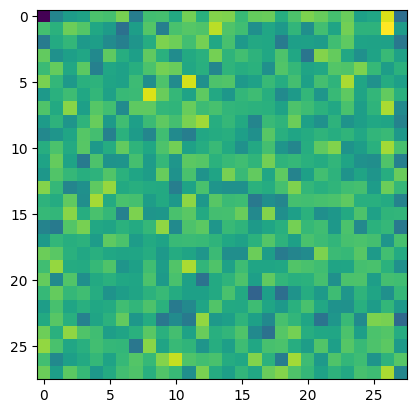

In [251]:
import matplotlib.pyplot as plt

sigmoid = nn.Sigmoid()
plt.imshow(test[0].view(28, 28))

In [123]:
torch.tensor([1,2,3]).repeat(4,4,2)

tensor([[[1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3]],

        [[1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3]],

        [[1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3]],

        [[1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3],
         [1, 2, 3, 1, 2, 3]]])

In [198]:
def embedtime(self, t, embedding_size, dimensions):
    emb = torch.zeros((embedding_size // 2) * t.shape[0]).reshape(t.shape[0], embedding_size // 2)
    emb2 = torch.zeros((embedding_size // 2) * t.shape[0]).reshape(t.shape[0], embedding_size // 2)
    s = torch.linspace(torch.tensor(2), torch.tensor(embedding_size // 2), torch.tensor(embedding_size // 2, dtype=int))
    for idx, samp in enumerate(t):
        emb[idx] = torch.sin(2 * s * torch.pi * samp / self.T)
        emb2[idx] = torch.cos(2 * s * torch.pi * samp / self.T)

    return torch.cat([emb, emb2], dim = 1).view(-1, embedding_size, 1, 1).repeat(1, 1, dimensions, dimensions)

torch.Size([16, 8, 8])

In [193]:
x.shape

torch.Size([3, 8])

In [ ]:
def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

In [177]:
a = torch.tensor([2]).repeat(1, 32 // 2) * torch.arange(0, 32, 2)
b = a = torch.tensor([2]).repeat(1, 32 // 2) * torch.arange(0, 32, 2)
torch.cat([a, b], dim = 1).view(-1, 32, 1, 1).repeat(1, 1, 16, 16)[0][1].shape

torch.Size([16, 16])